# Show some basics and options for the retrieval
This notebooks reads a sample spectra and illustrates the retrieval from Barret et al. (2019) and some sensitivities for the particle properties

In [1]:
from PSDretrieval import processRadar as pR
from PSDretrieval import plotting as pl
from PSDretrieval import scattering as sc
from PSDretrieval import retrievalUtils as rU
import snowScatt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SpecWindow = pR.loadSpectra(loadSample=True) #load sample spectra (window of several heights and time steps)
SpecSingle  = pR.selectSingleTimeHeight(SpecWindow)

In [3]:
SpecSingle

<xarray.Dataset>
Dimensions:           (doppler: 250)
Coordinates:
    time              datetime64[ns] 2019-01-22T14:55:00
    range             float32 1.008e+03
  * doppler           (doppler) float64 -2.0 -1.99 -1.98 ... 0.47 0.48 0.49
Data variables:
    WSpecH            (doppler) float64 ...
    KaSpecH           (doppler) float64 ...
    XSpecH            (doppler) float64 ...
    pa                float32 ...
    XSpecHspecNoise   float32 ...
    KaSpecHspecNoise  float32 ...
    DWR_X_Ka          (doppler) float64 ...
    DWR_Ka_W          (doppler) float64 ...

### plot the sample spectrum

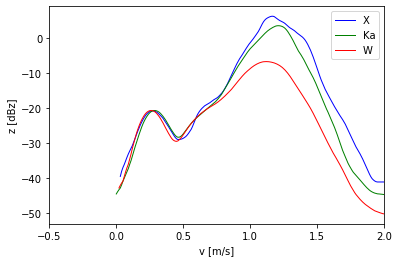

In [4]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax = pl.plotObsSpectra(SpecSingle,ax)

## 1. Calculate spectral DWR

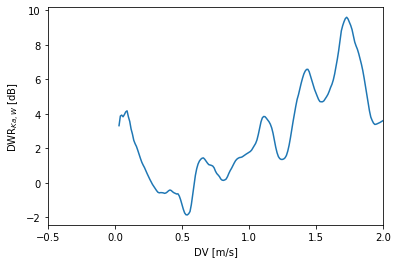

In [5]:
DWRkey="DWR_X_Ka"
fig,ax = plt.subplots(nrows=1,ncols=1)
ax = pl.plotSpectralDWR(SpecSingle[DWRkey],ax)

## 2. Get Dmax from sDWR taking predefined scattering properties from snowScatt
### 2.1 get unambiguous DWR-Dmax

In [6]:
snowScatt.snowLibrary.info() #use this line to show available particle types


print the information content in the database

##  List of AVERAGE properties

Name:  HW14
{'kappa': 0.19, 'beta': 0.23, 'gamma': 1.6666666666666667, 'zeta1': 1.0, 'aspect': 0.6, 'ar_mono': 1.0, 'am': 0.015, 'bm': 2.08, 'aa': nan, 'ba': nan}
Hogan and Westbrook 2014 aggregates of bullett rosettes

Name:  LS15A0.0
{'kappa': 0.189177, 'beta': 3.06939, 'gamma': 2.53192, 'zeta1': 0.0709529, 'aspect': 0.6, 'ar_mono': 0.3, 'am': 0.015, 'bm': 2.08, 'aa': nan, 'ba': nan}
Leinonen 2015 unrimed aggregates of dendrites

Name:  Oea14
{'kappa': 0.190031, 'beta': 0.030681461, 'gamma': 1.3002167, 'zeta1': 0.29466184, 'aspect': 0.9, 'ar_mono': 5.0, 'am': 0.157, 'bm': 2.1, 'aa': nan, 'ba': nan}
Ori 2014 assemblages of columns

##  List of tabulated size resolved properties

Name:  Leinonen15tabA00
Table of Leinonen unrimed snowflakes
Filepath : /home/mkarrer/.local/lib/python3.8/site-packages/snowScatt/snowProperties/ssrga_coeffs_simultaneous_0.0.csv

Name:  Leinonen15tabB00
Table of Leinonen unrimed s

DmaxRetr 10.0 DmaxAtDWRmax 9.797448724362182 DWRmin 13.528055501049902


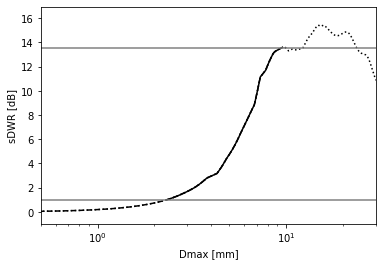

In [7]:
particleType = "vonTerzi_mixcoldend" #select a particle type

DWRxk,DWRkw,Dmax = sc.getDWRs(particleType,Dmax=np.linspace(0.3e-3, 50.0e-3, 2000),Kfreq="Ka") #get DWR(Dmax) relations from snowScatt
if DWRkey=="DWR_Ka_W":
    DWR = DWRkw
    DmaxRetr = 5e-3 #[m] maximum size considered in retrieval; this inexplicitly assumes that larger particles are not relevant
elif DWRkey=="DWR_X_Ka":
    DWR = DWRxk
    DmaxRetr = 1e-2 #[m] maximum size considered in retrieval; this inexplicitly assumes that larger particles are not relevant

DWRlowDetect = 1 #[dB] DWRs smaller than this are disregarded (detection limit)

fig,ax = plt.subplots(nrows=1,ncols=1)
DWRUnamb,ax = sc.getUnambigousDWRdmax(Dmax,DWR,DmaxRetr=DmaxRetr,DWRlowDetect=DWRlowDetect,showIllus=True,ax=ax) #get Unambiguous DWR-Dmax relation

## 3. get Dmax from sDWR at each velocity bin

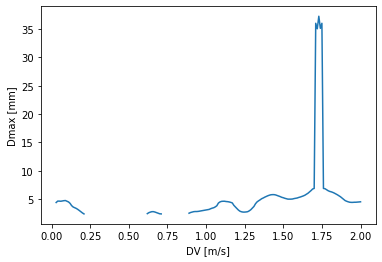

In [8]:
DmaxfromDWR = rU.getDmaxFromSDWR(SpecSingle[DWRkey],DWRUnamb,Dmax,showIllus=True,ax=None)

## 4. get mass from Dmax and the selected particle type

In [9]:
#get array of masses from the database #TODO: this is not really necessary because snowScatt selects the consistent m(D) anyway in "sc.model3fOne"
mass, __, __ = snowScatt.snowMassVelocityArea(DmaxfromDWR, particleType)

Text(0, 0.5, 'm [kg]')

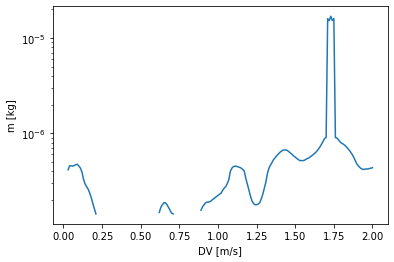

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.semilogy(-SpecSingle[DWRkey].doppler,mass)
ax.set_xlabel("DV [m/s]")
ax.set_ylabel("m [kg]")

## 5. get the single particle reflectivity

In [11]:
ZkOne = sc.getSinglePartRefl(particleType,DmaxfromDWR,freq="k")

## 6. divide the observed z (power at a specific DV) by Zone to get the number concentration N

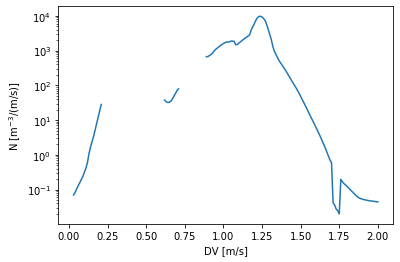

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=1)
Nnorm,ax = rU.calcNumberConcFromSpectrumAndZOne(SpecSingle.KaSpecH,ZkOne,showIllus=True,ax=ax)

# get dV/dD to transform from N(DV) to N(Dmax) space

/home/mkarrer/.local/lib/python3.8/site-packages/PSDretrieval/retrievalUtils.py:147: RuntimeWarning: invalid value encountered in greater
  yedgeDmaxValid              = yedgeDmax[yedgeDmax>0] #remove nans from yedgeDmax


(31,) (20,) (30, 20)
7.64828404998711 0.36400821581527837


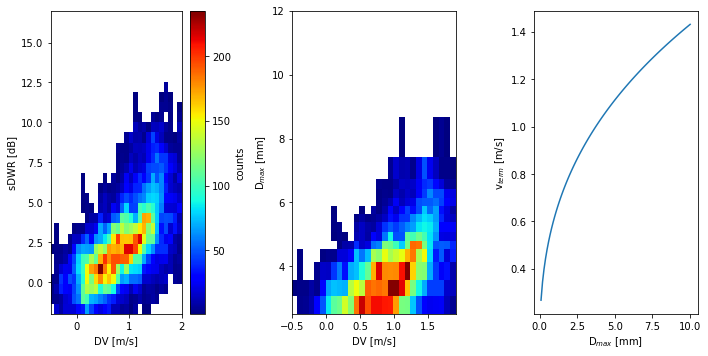

In [14]:
fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=3)
ax,hist,xedge,yedge = rU.histDWRandDmaxVsDv(SpecWindow[DWRkey],SpecWindow.KaSpecH,SpecWindow.KaSpecHspecNoise,DWRUnamb,Dmax,aboveNoiseThreshold=15,showIllus=True,ax=ax,fig=fig)

In [15]:
#DWRUnamb,ax = sc.getUnambigousDWRdmax(Dmax,DWRkw,DmaxRetr=5e-3,DWRlowDetect=1,showIllus=True,ax=ax) #get Unambiguous DWR-Dmax relation
#DmaxfromDWR = rU.getDmaxFromSDWR(SpecWindow[DWRkey],DWRUnamb,Dmax,showIllus=True,ax=None) #get Dmax fromDWR
#print(DmaxfromDWR)

In [16]:
rU.getDmaxFromSDWR(yedge,DWRUnamb,Dmax)

array([       nan,        nan,        nan,        nan,        nan,
       0.00251276, 0.00308459, 0.00358184, 0.00415368, 0.00455148,
       0.0048001 , 0.00509845, 0.0053968 , 0.00564542, 0.00589405,
       0.00616753, 0.00644102, 0.00676423, 0.03548034, 0.04226778,
       0.03088079, 0.00743552, 0.02854372, 0.02762381, 0.00867864,
              nan,        nan,        nan,        nan,        nan,
              nan])

In [17]:
isinstance(yedge, np.ndarray)

True